<a href="https://colab.research.google.com/github/alla-g/toxicity-detection-thesis/blob/main/testing_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing available toxicity detection models

## Получение данных

In [ ]:
%cd /content

/content


In [ ]:
! pwd

/content


In [ ]:
!git clone https://github.com/alla-g/toxicity-detection-thesis.git

In [ ]:
import re
import pandas as pd

In [ ]:
uncorrected_data = pd.read_csv('toxicity-detection-thesis/hypothesis_testing_data/uncorrected_data_NEW.tsv', sep='\t')
corrected_data = pd.read_csv('toxicity-detection-thesis/hypothesis_testing_data/corrected_data_NEW.tsv', sep='\t')
processed_data = pd.read_csv('toxicity-detection-thesis/hypothesis_testing_data/preprocessed_data_NEW.tsv', sep='\t')

Удалить ссылку на того, кому отвечают:

In [ ]:
pattern = re.compile('^\[.+\], ')
uncorrected_data['text'] = uncorrected_data['comments'].str.replace(pattern, '', regex=True)
corrected_data['text'] = corrected_data['corrected'].str.replace(pattern, '', regex=True)
processed_data['text'] = processed_data['preprocessed'].str.replace(pattern, '', regex=True)

Распределение классов:

In [ ]:
uncorrected_data['toxicity'].value_counts()

1    90
0    36
Name: toxicity, dtype: int64

## Обзор моделей
Перечислены все существующие модели и их результаты, недоступные для воспроизведения перечёркнуты

**Нейросетевые:**
* RuBERT (Smetanin, 2020) `0.922 F-score`.  
Модель **доступна** на [huggingface](https://huggingface.co/sismetanin/rubert-toxic-pikabu-2ch)
* ~~RuBERT (Saitov & Derczynski, 2021) `0.85 F-score`.  
Обученная модель недоступна, данные есть, можно взять их и учить заново - но не указаны гиперпараметры~~
* ~~CNN (Potapova & Gordeev, 2016) `0.667 accuracy`.  
Модель недоступна, данные недоступны, есть описание в статье~~
* RuBERT (Dale, n.d.) `no metrics`  
Модель **доступна** на [huggingface](https://huggingface.co/cointegrated/rubert-tiny-toxicity)
* wCNN + USE (Barsukov, 2021) `0.872 F-score`  
Модель **доступна** в питоновском модуле [toxicity](https://pypi.org/project/toxicity/)

**Классическое МО**:
* MNB (Smetanin, 2020) `0.832 F-score`  
Есть данные и параметры, можно обучить снова
* SVM (Saitov & Derczynski, 2021) `0.88 F-score`  
Для этого доступен [колаб](https://colab.research.google.com/drive/1slSZpA_OHZQgz4R4GzqVFdbVhWYz6aEn?usp=sharing) с препроцессингом и обучением
* ~~Random Forest (Potapova & Gordeev, 2016) `0.591 accuracy`  
Данных нет~~
* LogReg (Barsukov, 2021) `0.781 F-score`  
Тетрадка с кодом **доступна** по [ссылке](https://github.com/nsbarsukov/toxic-comments-detector)

### Нейросетевые

#### RuBERT (Smetanin, 2020)
`0.922 F-score`.  
Модель доступна на [huggingface](https://huggingface.co/sismetanin/rubert-toxic-pikabu-2ch)

In [ ]:
! pip install transformers

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
TextClassificationPipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, \
confusion_matrix

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def plot_matrix(golds, preds):
    """
    plots confusion matrix
    """
    cm = confusion_matrix(golds, preds)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('True Values ')

    ax.xaxis.set_ticklabels(['Not toxic','Toxic'])
    ax.yaxis.set_ticklabels(['Not toxic','Toxic'])

    plt.show()

In [ ]:
def save_predictions(uncor, cor, proc, modelname):
    """
    saves all predictions of one model to file
    """
    df = pd.DataFrame({'true_label': uncor['true_labels'],
                       'uncorrected_text': uncor['text'],
                       'pred_on_uncor': uncor['predicted'],
                       'corrected_text': cor['text'],
                       'pred_on_cor': cor['predicted'],
                       'processed_text': proc['text'],
                       'pred_on_proc': proc['predicted']})
    df.to_csv(f'{modelname}.tsv', sep='\t', index=False)
    print(f'{modelname} data saved successfully')

In [ ]:
rubert_smetanin_tokenizer = AutoTokenizer.from_pretrained('sismetanin/rubert-toxic-pikabu-2ch')
rubert_smetanin_model = AutoModelForSequenceClassification.from_pretrained('sismetanin/rubert-toxic-pikabu-2ch')

Downloading:   0%|          | 0.00/540 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/920 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/679M [00:00<?, ?B/s]

In [ ]:
pipe = TextClassificationPipeline(model=rubert_smetanin_model,
                                  tokenizer=rubert_smetanin_tokenizer,
                                  device=0)

In [ ]:
def eval_rubert_smetanin(pipe, dataset):
    """
    takes a pipe object and a dataset in df format, returns dictionaries
    with metrics and texts 
    """
    text_list = dataset.text.to_list()
    golds = dataset.toxicity.to_list()

    output = pipe(text_list)
    preds = [int(item['label'].split('_')[1]) for item in output]

    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    plot_matrix(golds, preds)
    
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
           {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

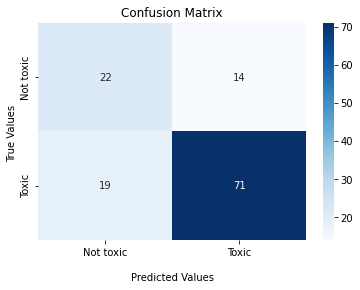

{'accuracy': 0.7380952380952381,
 'f1': 0.8114285714285714,
 'precision': 0.8352941176470589,
 'recall': 0.7888888888888889}

In [ ]:
uncor_rubert_smetanin, uncor_rubert_smetanin_data = eval_rubert_smetanin(pipe, uncorrected_data)
uncor_rubert_smetanin

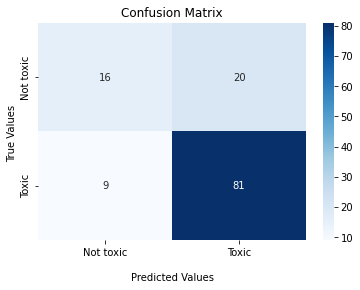

{'accuracy': 0.7698412698412699,
 'f1': 0.8481675392670157,
 'precision': 0.801980198019802,
 'recall': 0.9}

In [ ]:
cor_rubert_smetanin, cor_rubert_smetanin_data = eval_rubert_smetanin(pipe, corrected_data)
cor_rubert_smetanin

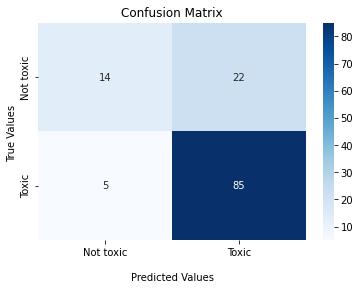

{'accuracy': 0.7857142857142857,
 'f1': 0.8629441624365483,
 'precision': 0.794392523364486,
 'recall': 0.9444444444444444}

In [ ]:
proc_rubert_smetanin, proc_rubert_smetanin_data = eval_rubert_smetanin(pipe, processed_data)
proc_rubert_smetanin

In [ ]:
save_predictions(uncor_rubert_smetanin_data,
                 cor_rubert_smetanin_data,
                 proc_rubert_smetanin_data,
                 'rubert_smetanin')

rubert_smetanin data saved successfully


In [ ]:
del pipe
del rubert_smetanin_model
del rubert_smetanin_tokenizer

#### RuBERT (Dale, n.d.)
`no metrics`  
Модель доступна на [huggingface](https://huggingface.co/cointegrated/rubert-tiny-toxicity)

In [ ]:
rubert_dale_tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-toxicity')
rubert_dale_model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-toxicity')

Downloading:   0%|          | 0.00/377 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.0M [00:00<?, ?B/s]

In [ ]:
pipe = TextClassificationPipeline(model=rubert_dale_model,
                                  tokenizer=rubert_dale_tokenizer,
                                  device=0)

In [ ]:
def eval_rubert_dale(pipe, dataset):
    """
    takes pipe object and a dataset in df format, returns dictionaries
    with metrics and texts
    """
    text_list = dataset.text.to_list()
    golds = dataset.toxicity.to_list()

    output = pipe(text_list)
    preds = [0 if item['label'] in ['non-toxic', 'obscenity'] else 1 for item in output]

    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    plot_matrix(golds, preds)

    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
            {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

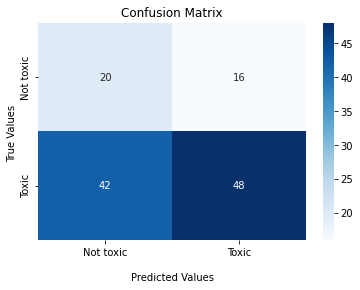

{'accuracy': 0.5396825396825397,
 'f1': 0.6233766233766235,
 'precision': 0.75,
 'recall': 0.5333333333333333}

In [ ]:
uncor_rubert_dale, uncor_rubert_dale_data = eval_rubert_dale(pipe, uncorrected_data)
uncor_rubert_dale

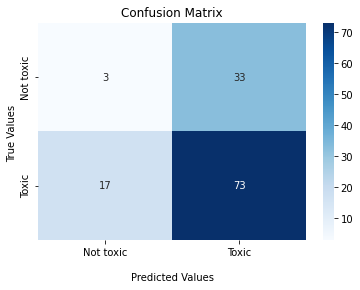

{'accuracy': 0.6031746031746031,
 'f1': 0.7448979591836735,
 'precision': 0.6886792452830188,
 'recall': 0.8111111111111111}

In [ ]:
cor_rubert_dale, cor_rubert_dale_data = eval_rubert_dale(pipe, corrected_data)
cor_rubert_dale

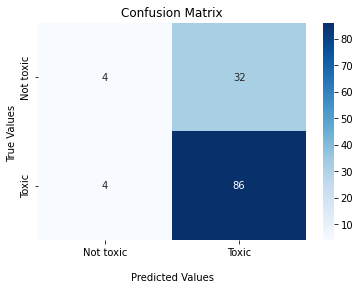

{'accuracy': 0.7142857142857143,
 'f1': 0.8269230769230769,
 'precision': 0.7288135593220338,
 'recall': 0.9555555555555556}

In [ ]:
proc_rubert_dale, proc_rubert_dale_data = eval_rubert_dale(pipe, processed_data)
proc_rubert_dale

In [ ]:
save_predictions(uncor_rubert_dale_data,
                 cor_rubert_dale_data,
                 proc_rubert_dale_data,
                 'rubert_dale')

rubert_dale data saved successfully


In [ ]:
del pipe
del rubert_dale_model
del rubert_dale_tokenizer

#### wCNN + USE (Barsukov, 2021)
`0.872 F-score`  
Модель доступна в питоновском модуле [toxicity](https://pypi.org/project/toxicity/)

In [ ]:
! pip install toxicity

     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 8.2 MB 22.1 MB/s 
     |████████████████████████████████| 462 kB 66.1 MB/s 
  Created wheel for toxicity: filename=toxicity-0.30-py3-none-any.whl size=57647021 sha256=345575816c09e6b6eee0b78aa9fedf914db8688de69a02b3f4c405bc7ae208f0
  Stored in directory: /root/.cache/pip/wheels/94/e6/8a/965d54385b5cf08e61676bd1ecb40a92e8d0b8210a9c47e2d9
Successfully built toxicity


In [ ]:
from toxicity import ToxicCommentsDetector

In [ ]:
toxicDetector = ToxicCommentsDetector()

In [ ]:
def eval_cnn_barsukov(detector, dataset):
    """
    takes detector object and a dataset in df format, returns dictionaries
    with metrics and texts
    """
    text_list = dataset.text.to_list()
    golds = dataset.toxicity.to_list()

    output = detector.predict(text_list)
    preds = [0 if score < 0.5 else 1 for score in output]

    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    plot_matrix(golds, preds)
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
            {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

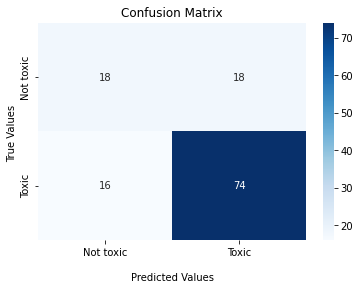

{'accuracy': 0.7301587301587301,
 'f1': 0.8131868131868132,
 'precision': 0.8043478260869565,
 'recall': 0.8222222222222222}

In [ ]:
uncor_cnn_barsukov, uncor_cnn_barsukov_data = eval_cnn_barsukov(toxicDetector, uncorrected_data)
uncor_cnn_barsukov

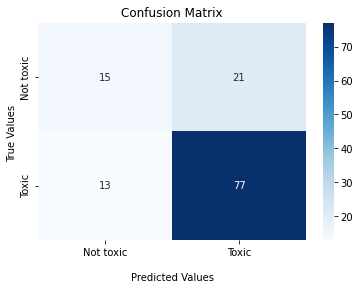

{'accuracy': 0.7301587301587301,
 'f1': 0.8191489361702127,
 'precision': 0.7857142857142857,
 'recall': 0.8555555555555555}

In [ ]:
cor_cnn_barsukov, cor_cnn_barsukov_data = eval_cnn_barsukov(toxicDetector, corrected_data)
cor_cnn_barsukov

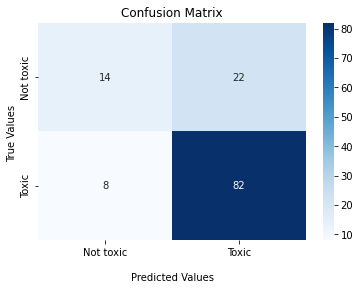

{'accuracy': 0.7619047619047619,
 'f1': 0.845360824742268,
 'precision': 0.7884615384615384,
 'recall': 0.9111111111111111}

In [ ]:
proc_cnn_barsukov, proc_cnn_barsukov_data = eval_cnn_barsukov(toxicDetector, processed_data)
proc_cnn_barsukov

In [ ]:
save_predictions(uncor_cnn_barsukov_data,
                 cor_cnn_barsukov_data,
                 proc_cnn_barsukov_data,
                 'cnn_barsukov')

cnn_barsukov data saved successfully


#### Сравнение

In [ ]:
results = pd.DataFrame(uncor_rubert_smetanin, index=['uncor_rubert_smetanin'])
results.loc['cor_rubert_smetanin'] = cor_rubert_smetanin
results.loc['proc_rubert_smetanin'] = proc_rubert_smetanin
results.loc['uncor_rubert_dale'] = uncor_rubert_dale
results.loc['cor_rubert_dale'] = cor_rubert_dale
results.loc['proc_rubert_dale'] = proc_rubert_dale
results.loc['uncor_cnn_barsukov'] = uncor_cnn_barsukov
results.loc['cor_cnn_barsukov'] = cor_cnn_barsukov
results.loc['proc_cnn_barsukov'] = proc_cnn_barsukov

results.style.highlight_max(axis=0)

,accuracy,f1,precision,recall
uncor_rubert_smetanin,0.738095,0.811429,0.835294,0.788889
cor_rubert_smetanin,0.769841,0.848168,0.801980,0.900000
proc_rubert_smetanin,0.785714,0.862944,0.794393,0.944444
uncor_rubert_dale,0.539683,0.623377,0.750000,0.533333
cor_rubert_dale,0.603175,0.744898,0.688679,0.811111
proc_rubert_dale,0.714286,0.826923,0.728814,0.955556
uncor_cnn_barsukov,0.730159,0.813187,0.804348,0.822222
cor_cnn_barsukov,0.730159,0.819149,0.785714,0.855556
proc_cnn_barsukov,0.761905,0.845361,0.788462,0.911111


In [ ]:
results_f1 = pd.DataFrame({'uncorrected': uncor_rubert_smetanin['f1'],
                           'corrected': cor_rubert_smetanin['f1'],
                           'preprocessed': proc_rubert_smetanin['f1']}, index=['rubert_smetanin'])

results_f1.loc['rubert_dale'] = {'uncorrected': uncor_rubert_dale['f1'],
                                 'corrected': cor_rubert_dale['f1'],
                                 'preprocessed': proc_rubert_dale['f1']}

results_f1.loc['cnn_barsukov'] = {'uncorrected': uncor_cnn_barsukov['f1'],
                                  'corrected': cor_cnn_barsukov['f1'],
                                  'preprocessed': proc_cnn_barsukov['f1']}

results_f1.style.highlight_max(axis=1, color='orange')

,uncorrected,corrected,preprocessed
rubert_smetanin,0.811429,0.848168,0.862944
rubert_dale,0.623377,0.744898,0.826923
cnn_barsukov,0.813187,0.819149,0.845361


### Классические

#### MNB (Smetanin, 2020)  
`0.832 F-score`  
Есть данные в [статье](https://www.dialog-21.ru/media/5181/smetaninsi-029.pdf):  "to build the MNB model, we used the Bag-of-Words model
and the TF-IDF vectorization". 

Preprocessing:  
replace URLs and usernames with keywords,  
remove punctuation marks,  
convert strings into lowercase". 

In [ ]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [ ]:
def preprocess(text):
    """
    preprocess text as described in the paper
    """
    # replace URLs
    text =  re.sub('https?[0-9a-zA-Z.:/]*', '#LINK', text)

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # convert to lowercase
    text = text.lower()

    return text

In [ ]:
# not publicly available in my repo, please refer to the original upload on kaggle:
# https://www.kaggle.com/blackmoon/russian-language-toxic-comments
rltc = pd.read_csv('toxicity-detection-thesis/hypothesis_testing_data/kaggle_rltc.csv')

In [ ]:
rltc.toxic = rltc.toxic.astype('int64')
rltc.comment = rltc.comment.apply(preprocess)
rltc.head(5)

,comment,toxic
0,верблюдовто за что дебилы бл\n,1
1,хохлы это отдушина затюканого россиянина мол в...,1
2,собаке собачья смерть\n,1
3,страницу обнови дебил это тоже не оскорбление ...,1
4,тебя не убедил 6страничный пдф в том что скрип...,1


In [ ]:
vectorizer = TfidfVectorizer(min_df=7)
vectorized = vectorizer.fit_transform(rltc.comment.values.astype('U')).toarray()

x_train, _, y_train, _ = train_test_split(vectorized, rltc.toxic.tolist(),
                                          test_size=0.2, random_state=42)

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)

MultinomialNB()

In [ ]:
def eval_mnb_smetanin(clf, dataset):
    """
    takes clf object and a dataset in df format, returns dictionaries
    with metrics and texts
    """
    text_list = dataset.text.apply(preprocess).to_list()
    golds = dataset.toxicity.to_list()

    vectorized = vectorizer.transform(text_list).toarray()
    preds = clf.predict(vectorized)

    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    plot_matrix(golds, preds)
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
            {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

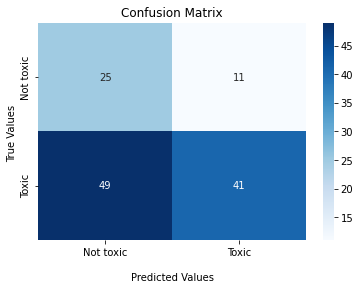

{'accuracy': 0.5238095238095238,
 'f1': 0.5774647887323944,
 'precision': 0.7884615384615384,
 'recall': 0.45555555555555555}

In [ ]:
uncor_mnb_smetanin, uncor_mnb_smetanin_data = eval_mnb_smetanin(mnb, uncorrected_data)
uncor_mnb_smetanin

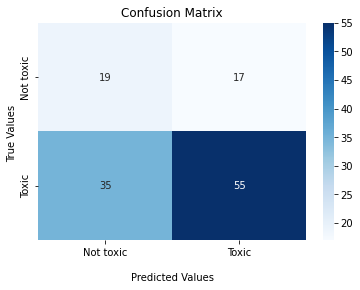

{'accuracy': 0.5873015873015873,
 'f1': 0.6790123456790124,
 'precision': 0.7638888888888888,
 'recall': 0.6111111111111112}

In [ ]:
cor_mnb_smetanin, cor_mnb_smetanin_data = eval_mnb_smetanin(mnb, corrected_data)
cor_mnb_smetanin

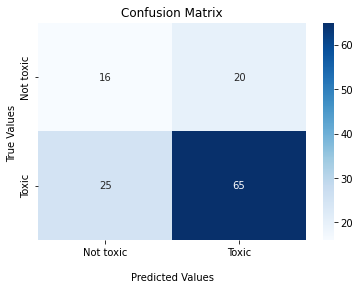

{'accuracy': 0.6428571428571429,
 'f1': 0.7428571428571428,
 'precision': 0.7647058823529411,
 'recall': 0.7222222222222222}

In [ ]:
proc_mnb_smetanin, proc_mnb_smetanin_data = eval_mnb_smetanin(mnb, processed_data)
proc_mnb_smetanin

In [ ]:
save_predictions(uncor_mnb_smetanin_data,
                 cor_mnb_smetanin_data,
                 proc_mnb_smetanin_data,
                 'mnb_smetanin')

mnb_smetanin data saved successfully


#### SVM (Saitov & Derczynski, 2021)  
`0.88 F-score`  
Для этого доступен [колаб](https://colab.research.google.com/drive/1slSZpA_OHZQgz4R4GzqVFdbVhWYz6aEn?usp=sharing) с препроцессингом и обучением

In [ ]:
%cd /content

/content


In [ ]:
# ! git clone https://github.com/Sariellee/Russan-Hate-speech-Recognition

# my fork with adapted code
! git clone https://github.com/alla-g/Russan-Hate-speech-Recognition

Cloning into 'Russan-Hate-speech-Recognition'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 77 (delta 25), reused 6 (delta 1), pack-reused 27
Unpacking objects: 100% (77/77), done.


In [ ]:
%cd Russan-Hate-speech-Recognition

[Errno 2] No such file or directory: 'Russan-Hate-speech-Recognition'
/content/Russan-Hate-speech-Recognition


In [ ]:
%pwd

'/content/Russan-Hate-speech-Recognition'

In [ ]:
! pip install -r requirements.txt

In [ ]:
! wget https://storage.b-labs.pro/models/fasttext-social-network-model.bin

--2022-05-07 15:16:38--  https://storage.b-labs.pro/models/fasttext-social-network-model.bin
Resolving storage.b-labs.pro (storage.b-labs.pro)... 172.67.160.159, 104.21.14.222, 2606:4700:3035::6815:ede, ...
Connecting to storage.b-labs.pro (storage.b-labs.pro)|172.67.160.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84051390 (80M) [application/x-sega-cd-rom]
Saving to: ‘fasttext-social-network-model.bin’

fasttext-social-net 100%[===================>]  80.16M  77.6MB/s    in 1.0s    

2022-05-07 15:16:39 (77.6 MB/s) - ‘fasttext-social-network-model.bin’ saved [84051390/84051390]



In [ ]:
! python main.py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

label 0: 10663 samples
label 1: 5212 samples
data proportion is: 0.67/0.33

AFTER REBALANCING

label 0: 5451 samples
label 1: 5212 samples
data proportion is: 0.51/0.49

preprocessing stage 1..
extraction of features..
acquring TF-IDF features..
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
preprocessing stage 2..
extracting features..
training model..
extraction of features..
initiating sentiment analyzer..
acquring TF-IDF features for uncor..
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarni

#### LogReg (Barsukov, 2021)

In [ ]:
# from https://github.com/nsbarsukov/toxic-comments-detector/blob/master/models/00baseModelLogRegr.ipynb
! git clone https://github.com/nsbarsukov/toxic-comments-detector

Cloning into 'toxic-comments-detector'...
remote: Enumerating objects: 876, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 876 (delta 4), reused 4 (delta 4), pack-reused 852
Receiving objects: 100% (876/876), 97.15 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (497/497), done.


In [ ]:
%cd /content/toxic-comments-detector

/content/toxic-comments-detector


code below is taken from [original notebook](https://github.com/nsbarsukov/toxic-comments-detector/blob/master/models/00baseModelLogRegr.ipynb)

In [ ]:
import sys
import sklearn
import nltk

# local imports
from dev import (
    load_cleaned_russian_text_data,
    evaluate_model,
    SEED
)

In [ ]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

In [ ]:
! pip install pymorphy2

In [ ]:
# add my test data
from textPreprocessing import preprocess_text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

vectorizer = CountVectorizer(
    min_df=3,
    stop_words=stopwords.words('russian')
)

vectorizer.fit(X_train.flatten());

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_train = vectorizer.transform(X_train.flatten())

X_test = vectorizer.transform(X_test.flatten())

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train);

In [ ]:
def eval_logreg_barsukov(clf, dataset):
    """
    takes clf object and a dataset in df format, returns dictionaries
    with metrics and texts
    """
    text_list = dataset.text.apply(preprocess_text).to_list()
    golds = dataset.toxicity.to_list()

    vectorized = vectorizer.transform(text_list).toarray()
    preds = clf.predict(vectorized)

    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    plot_matrix(golds, preds)
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
            {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

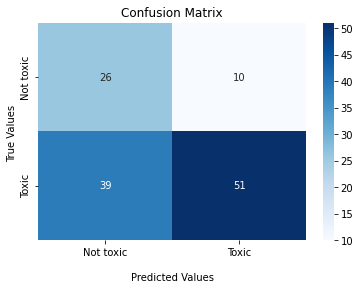

{'accuracy': 0.6111111111111112,
 'f1': 0.6754966887417219,
 'precision': 0.8360655737704918,
 'recall': 0.5666666666666667}

In [ ]:
uncor_logreg_barsukov, uncor_logreg_barsukov_data = eval_logreg_barsukov(logreg, uncorrected_data)
uncor_logreg_barsukov

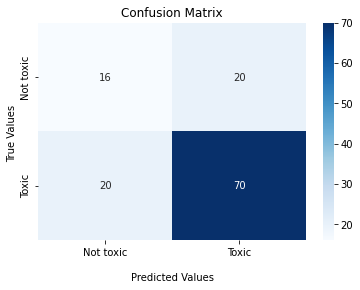

{'accuracy': 0.6825396825396826,
 'f1': 0.7777777777777778,
 'precision': 0.7777777777777778,
 'recall': 0.7777777777777778}

In [ ]:
cor_logreg_barsukov, cor_logreg_barsukov_data = eval_logreg_barsukov(logreg, corrected_data)
cor_logreg_barsukov

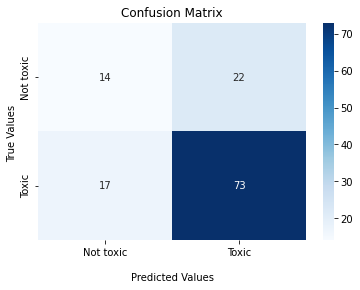

{'accuracy': 0.6904761904761905,
 'f1': 0.7891891891891891,
 'precision': 0.7684210526315789,
 'recall': 0.8111111111111111}

In [ ]:
proc_logreg_barsukov, proc_logreg_barsukov_data = eval_logreg_barsukov(logreg, processed_data)
proc_logreg_barsukov

In [ ]:
save_predictions(uncor_logreg_barsukov_data,
                 cor_logreg_barsukov_data,
                 proc_logreg_barsukov_data,
                 'logreg_barsukov')

logreg_barsukov data saved successfully


### Мои модели
* данные vk + 1 задача
* данные vk + 2 задачи
* все имеющиеся данные + 1 задача
* все имеющиеся данные + 2 задачи 

In [ ]:
%cd /content

/content


In [ ]:
! git clone https://github.com/hellohaptik/multi-task-NLP.git
%cd multi-task-NLP
! pip install -r requirements.txt

fatal: destination path 'multi-task-NLP' already exists and is not an empty directory.
/content/multi-task-NLP
  Using cached seqeval-0.0.12-py3-none-any.whl
  Using cached ipywidgets-7.4.2-py2.py3-none-any.whl (111 kB)
  Using cached tensorflow-1.15.2-cp37-cp37m-manylinux2010_x86_64.whl (110.5 MB)
  Using cached sphinx_rtd_theme-0.4.3-py2.py3-none-any.whl (6.4 MB)
  Using cached pandas-1.0.1-cp37-cp37m-manylinux1_x86_64.whl (10.1 MB)
  Using cached scikit_learn-0.23.1-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.0
    Uninstalling ipywidgets-7.7.0:
      Successfully uninstalled ipywi

In [ ]:
import sys
sys.path.insert(0,'/content/multi-task-NLP')

In [ ]:
from infer_pipeline import inferPipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, \
confusion_matrix

Using TensorFlow backend.


In [ ]:
def eval_multitask_model(pipe, dataset, need_matrix=False):
    """
    takes a pipe object and a dataset in df format, returns dictionaries
    with metrics and texts
    """
    text_list = [[text] for text in dataset.text.to_list()]
    golds = dataset.toxicity.to_list()

    output = pipe.infer(text_list, ['ToxicityDetection'])
    preds = [answer['ToxicityDetection'][0] for answer in output]
    precision, recall, f1, _ = precision_recall_fscore_support(golds, preds,
                                                               average='binary')
    acc = accuracy_score(golds, preds)
    if need_matrix:
        plot_matrix(golds, preds)
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}, \
            {'true_labels': golds,
            'text': text_list,
            'predicted': preds}

#### vk data, 1 task

In [ ]:
# vk data, 1 task
!gdown https://drive.google.com/uc?id=1barEeEUgEUXHHkYN-l-s2i8AZYEyTtYp

Downloading...
From: https://drive.google.com/uc?id=1barEeEUgEUXHHkYN-l-s2i8AZYEyTtYp
To: /content/multi-task-NLP/1Tvk_multi_task_model_3_1160.pt
100% 2.14G/2.14G [00:19<00:00, 109MB/s]


In [ ]:
vk_1T_pipe = inferPipeline(modelPath = '/content/multi-task-NLP/1Tvk_multi_task_model_3_1160.pt',
                           maxSeqLen = 128)

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.58it/s]


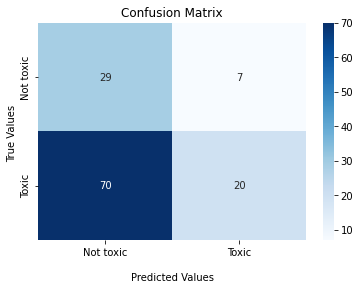

{'accuracy': 0.3888888888888889,
 'f1': 0.34188034188034183,
 'precision': 0.7407407407407407,
 'recall': 0.2222222222222222}

In [ ]:
uncor_vk_1T, uncor_vk_1T_data = eval_multitask_model(vk_1T_pipe, uncorrected_data, need_matrix=True)
uncor_vk_1T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 14.09it/s]


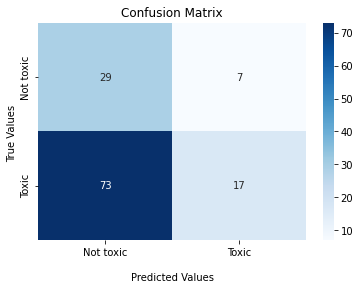

{'accuracy': 0.36507936507936506,
 'f1': 0.2982456140350877,
 'precision': 0.7083333333333334,
 'recall': 0.18888888888888888}

In [ ]:
cor_vk_1T, cor_vk_1T_data = eval_multitask_model(vk_1T_pipe, corrected_data, need_matrix=True)
cor_vk_1T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.86it/s]


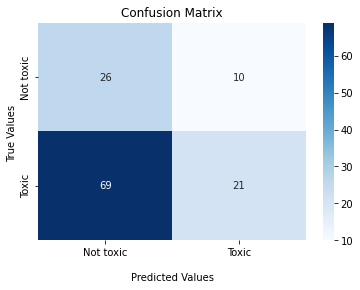

{'accuracy': 0.373015873015873,
 'f1': 0.34710743801652894,
 'precision': 0.6774193548387096,
 'recall': 0.23333333333333334}

In [ ]:
preproc_vk_1T, preproc_vk_1T_data = eval_multitask_model(vk_1T_pipe, processed_data, need_matrix=True)
preproc_vk_1T

In [ ]:
save_predictions(uncor_vk_1T_data,
                 cor_vk_1T_data,
                 preproc_vk_1T_data,
                 'vk_1T')

vk_1T data saved successfully


In [ ]:
del vk_1T_pipe

#### vk data, 2 tasks

In [ ]:
# vk data, 2 tasks
!gdown https://drive.google.com/uc?id=1--iwGBQHBUXXktC9kqHllnmPzwN9wRYz

Downloading...
From: https://drive.google.com/uc?id=1--iwGBQHBUXXktC9kqHllnmPzwN9wRYz
To: /content/2Tvk_multi_task_model_3_1880.pt
100% 2.14G/2.14G [00:09<00:00, 228MB/s]


In [ ]:
vk_2T_pipe = inferPipeline(modelPath = '/content/multi-task-NLP/2Tvk_multi_task_model_3_1880.pt',
                           maxSeqLen = 128)

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


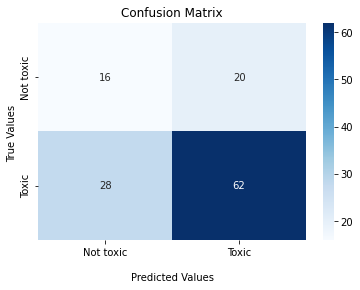

{'accuracy': 0.6190476190476191,
 'f1': 0.7209302325581395,
 'precision': 0.7560975609756098,
 'recall': 0.6888888888888889}

In [ ]:
uncor_vk_2T, uncor_vk_2T_data = eval_multitask_model(vk_2T_pipe, uncorrected_data, need_matrix=True)
uncor_vk_2T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 14.16it/s]


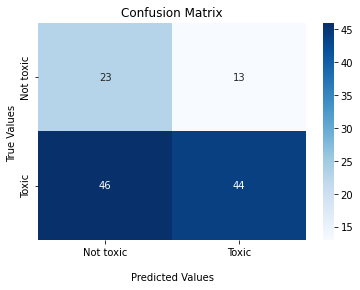

{'accuracy': 0.5317460317460317,
 'f1': 0.5986394557823128,
 'precision': 0.7719298245614035,
 'recall': 0.4888888888888889}

In [ ]:
cor_vk_2T, cor_vk_2T_data = eval_multitask_model(vk_2T_pipe, corrected_data, need_matrix=True)
cor_vk_2T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.55it/s]


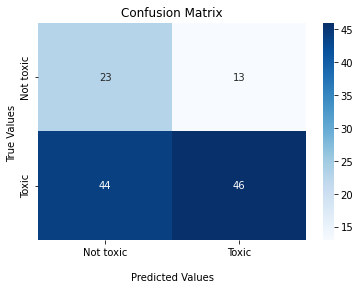

{'accuracy': 0.5476190476190477,
 'f1': 0.6174496644295301,
 'precision': 0.7796610169491526,
 'recall': 0.5111111111111111}

In [ ]:
preproc_vk_2T, preproc_vk_2T_data = eval_multitask_model(vk_2T_pipe, processed_data, need_matrix=True)
preproc_vk_2T

In [ ]:
save_predictions(uncor_vk_2T_data,
                 cor_vk_2T_data,
                 preproc_vk_2T_data,
                 'vk_2T')

vk_2T data saved successfully


In [ ]:
del vk_2T_pipe

#### all data, 1 task

In [ ]:
# all data, 1 task
!gdown https://drive.google.com/uc?id=1gJ1IPzpaVG81EzyyF7l9m67L_IbH4uZQ

Downloading...
From: https://drive.google.com/uc?id=1gJ1IPzpaVG81EzyyF7l9m67L_IbH4uZQ
To: /content/1Talldata_multi_task_model_3_3472.pt
100% 2.14G/2.14G [00:10<00:00, 195MB/s]


In [ ]:
alldata_1T_pipe = inferPipeline(modelPath = '/content/multi-task-NLP/1Talldata_multi_task_model_3_3472.pt',
                                maxSeqLen = 128)

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.67it/s]


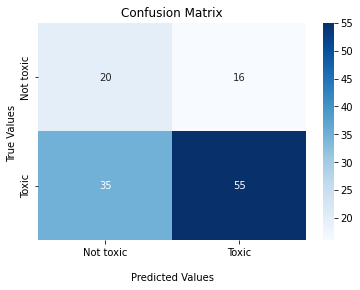

{'accuracy': 0.5952380952380952,
 'f1': 0.6832298136645963,
 'precision': 0.7746478873239436,
 'recall': 0.6111111111111112}

In [ ]:
uncor_alldata_1T, uncor_alldata_1T_data = eval_multitask_model(alldata_1T_pipe, uncorrected_data, need_matrix=True)
uncor_alldata_1T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.24it/s]


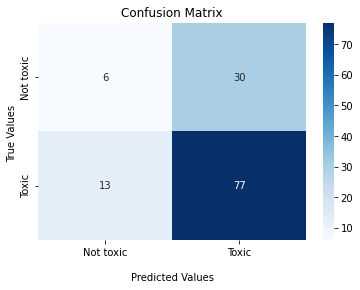

{'accuracy': 0.6587301587301587,
 'f1': 0.7817258883248731,
 'precision': 0.719626168224299,
 'recall': 0.8555555555555555}

In [ ]:
cor_alldata_1T, cor_alldata_1T_data = eval_multitask_model(alldata_1T_pipe, corrected_data, need_matrix=True)
cor_alldata_1T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 14.12it/s]


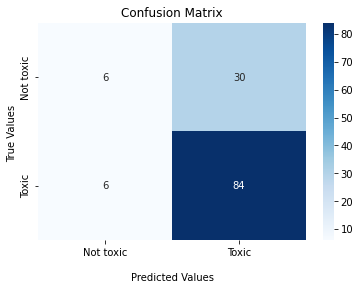

{'accuracy': 0.7142857142857143,
 'f1': 0.8235294117647058,
 'precision': 0.7368421052631579,
 'recall': 0.9333333333333333}

In [ ]:
preproc_alldata_1T, preproc_alldata_1T_data = eval_multitask_model(alldata_1T_pipe, processed_data, need_matrix=True)
preproc_alldata_1T

In [ ]:
save_predictions(uncor_alldata_1T_data,
                 cor_alldata_1T_data,
                 preproc_alldata_1T_data,
                 'alldata_1T')

alldata_1T data saved successfully


In [ ]:
del alldata_1T_pipe

#### all data, 2 tasks

In [ ]:
# all data, 2 tasks
!gdown https://drive.google.com/uc?id=1Xu-4-3kYv8HCU2j7zgx84FZm778lzIKk

Downloading...
From: https://drive.google.com/uc?id=1Xu-4-3kYv8HCU2j7zgx84FZm778lzIKk
To: /content/multi-task-NLP/2Talldata_multi_task_model_3_4192.pt
100% 2.14G/2.14G [00:15<00:00, 139MB/s]


In [ ]:
alldata_2T_pipe = inferPipeline(modelPath = '/content/multi-task-NLP/2Talldata_multi_task_model_3_4192.pt',
                                maxSeqLen = 128)

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]


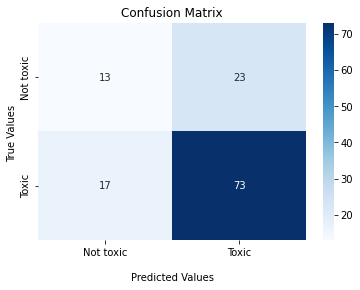

{'accuracy': 0.6825396825396826,
 'f1': 0.7849462365591398,
 'precision': 0.7604166666666666,
 'recall': 0.8111111111111111}

In [ ]:
uncor_alldata_2T, uncor_alldata_2T_data = eval_multitask_model(alldata_2T_pipe, uncorrected_data, need_matrix=True)
uncor_alldata_2T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 14.47it/s]


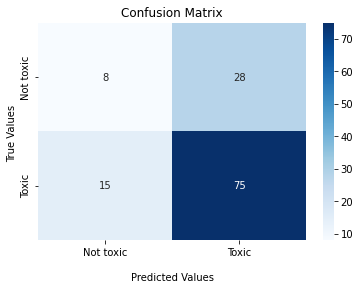

{'accuracy': 0.6587301587301587,
 'f1': 0.7772020725388602,
 'precision': 0.7281553398058253,
 'recall': 0.8333333333333334}

In [ ]:
cor_alldata_2T, cor_alldata_2T_data = eval_multitask_model(alldata_2T_pipe, corrected_data, need_matrix=True)
cor_alldata_2T

Eval:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Eval: 100%|██████████| 16/16 [00:01<00:00, 13.78it/s]


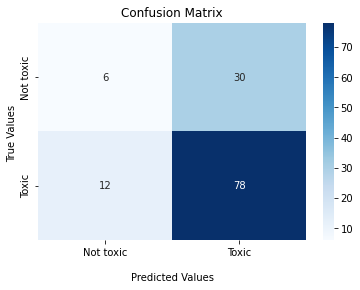

{'accuracy': 0.6666666666666666,
 'f1': 0.7878787878787877,
 'precision': 0.7222222222222222,
 'recall': 0.8666666666666667}

In [ ]:
preproc_alldata_2T, preproc_alldata_2T_data = eval_multitask_model(alldata_2T_pipe, processed_data, need_matrix=True)
preproc_alldata_2T

In [ ]:
save_predictions(uncor_alldata_2T_data,
                 cor_alldata_2T_data,
                 preproc_alldata_2T_data,
                 'alldata_2T')

alldata_2T data saved successfully


In [ ]:
del alldata_2T_pipe

In [ ]:
import json
# save to load after restarting runtime
my_metrics = {'uncor_alldata_2T': uncor_alldata_2T,
              'cor_alldata_2T': cor_alldata_2T,
              'preproc_alldata_2T': preproc_alldata_2T,
              'uncor_vk_2T': uncor_vk_2T,
              'cor_vk_2T': cor_vk_2T,
              'preproc_vk_2T': preproc_vk_2T,
              'uncor_vk_1T': uncor_vk_1T,
              'cor_vk_1T': cor_vk_1T,
              'preproc_vk_1T': preproc_vk_1T,
              'uncor_alldata_1T': uncor_alldata_1T,
              'cor_alldata_1T': cor_alldata_1T,
              'preproc_alldata_1T': preproc_alldata_1T}

with open('metrics.json', 'w') as f:
    json.dump(my_metrics, f)

#### Сравнение

In [ ]:
! pip install pandas -U
! pip install numpy -U

     |████████████████████████████████| 11.3 MB 5.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.30.0 which is incompatible.


     |████████████████████████████████| 15.7 MB 5.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.2.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.2.0 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.30.0 which is incompatible.
librosa 0.8.1 requires joblib>=0.14, but you have joblib 0.13.2 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have

In [ ]:
import json
import pandas as pd
import numpy as np

In [ ]:
# load after restart runtime
with open('/content/multi-task-NLP/metrics.json', 'r') as f:
    my_metrics = json.load(f)

In [ ]:
my_results = pd.DataFrame.from_dict(my_metrics, orient='index')
my_results.style.highlight_max(axis=0)

,accuracy,f1,precision,recall
uncor_alldata_2T,0.682540,0.784946,0.760417,0.811111
cor_alldata_2T,0.658730,0.777202,0.728155,0.833333
preproc_alldata_2T,0.666667,0.787879,0.722222,0.866667
uncor_vk_2T,0.619048,0.720930,0.756098,0.688889
cor_vk_2T,0.531746,0.598639,0.771930,0.488889
preproc_vk_2T,0.547619,0.617450,0.779661,0.511111
uncor_vk_1T,0.388889,0.341880,0.740741,0.222222
cor_vk_1T,0.365079,0.298246,0.708333,0.188889
preproc_vk_1T,0.373016,0.347107,0.677419,0.233333
uncor_alldata_1T,0.595238,0.683230,0.774648,0.611111


In [ ]:
my_results_f1 = pd.DataFrame({'uncorrected': my_metrics['uncor_vk_1T']['f1'],
                              'corrected': my_metrics['cor_vk_1T']['f1'],
                              'preprocessed': my_metrics['preproc_vk_1T']['f1']},
                             index=['vkdata_onetask'])

my_results_f1.loc['vkdata_twotasks'] = {'uncorrected': my_metrics['uncor_vk_2T']['f1'],
                                        'corrected': my_metrics['cor_vk_2T']['f1'],
                                        'preprocessed': my_metrics['preproc_vk_2T']['f1']}

my_results_f1.loc['alldata_onetask'] = {'uncorrected': my_metrics['uncor_alldata_1T']['f1'],
                                         'corrected': my_metrics['cor_alldata_1T']['f1'],
                                         'preprocessed': my_metrics['preproc_alldata_1T']['f1']}

my_results_f1.loc['alldata_twotasks'] = {'uncorrected': my_metrics['uncor_alldata_2T']['f1'],
                                         'corrected': my_metrics['cor_alldata_2T']['f1'],
                                         'preprocessed': my_metrics['preproc_alldata_2T']['f1']}

my_results_f1.style.highlight_max(axis=1, color='orange')

,uncorrected,corrected,preprocessed
vkdata_onetask,0.341880,0.298246,0.347107
vkdata_twotasks,0.720930,0.598639,0.617450
alldata_onetask,0.683230,0.781726,0.823529
alldata_twotasks,0.784946,0.777202,0.787879


In [ ]:
# models that were tested before

,uncorrected,corrected,preprocessed
rubert_smetanin,0.811429,0.848168,0.862944
rubert_dale,0.623377,0.744898,0.826923
cnn_barsukov,0.813187,0.819149,0.845361


model           | uncorrected | corrected | preprocessed 
----------------|-------------|-----------|-------------
mnb_smetanin    | 0.5775      | 0.6790    | **0.7429**
svm_saitov      | **0.81**    | 0.80      | **0.81**
logreg_barsukov | 0.6755      | 0.7778    | **0.7891**